In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
import os
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.reset()
# Fashion - MNIST - https://github.com/zalandoresearch/fashion-mnist
mnist = keras.datasets.mnist
fashion_mnist = keras.datasets.fashion_mnist
cifar10 = keras.datasets.cifar10
#(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
#(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_images = train_images.reshape((50000,  32, 32,3))
test_images = test_images.reshape((10000, 32, 32,3))


# import scipy.ndimage as ndi
# train_images_z = ndi.zoom(train_images, (1, 512/28.0, 512/28.0, 1), order=2)

# normalize inputs from 0-255 to 0.0-1.0
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images_norm = train_images / 255.0
test_images_norm = test_images / 255.0


def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst


train_images_norm = grayscale(train_images_norm)
test_images_norm = grayscale(test_images_norm)


/home/hegder/anaconda3/envs/dlm/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hegder/anaconda3/envs/dlm/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hegder/anaconda3/envs/dlm/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hegder/anaconda3/envs/dlm/lib/python3.6/site-pack

In [2]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Activation
from keras.layers import Dropout, UpSampling2D, ZeroPadding2D
from keras.layers import Flatten, Cropping1D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.engine.topology import Layer
from keras.layers import Lambda, Input
import tensorflow as tf


class Hadamard(Layer):

    def __init__(self, **kwargs):
        #self.output_dim = output_dim
        #super(MyLayer, self).__init__(**kwargs)
        super(Hadamard, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      #shape=(input_shape[1], self.output_dim),
                                      shape=(1,) + input_shape[1:],
                                      initializer='uniform',                                      
                                      trainable=True)
        super(Hadamard, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        #print(x.shape, self.kernel.shape)
        return x * tf.exp(2.0*np.pi*1j*tf.keras.backend.cast(self.kernel, dtype='complex64')           )

    def compute_output_shape(self, input_shape):
        #print(input_shape)
        return input_shape


def propagate(x):
    N = 256
    d = 40 # plate spacing
    lam = 1    # wavelength 
    P = 0.5  # pitch of metasurface
    df = 1.0/(N*P)
    k = np.pi*2.0/lam
    

    def phase(i,j):
        i -= N//2
        j -= N//2
        return ((i*df)*(i*df)+(j*df)*(j*df))
    ph  = np.fromfunction(phase,shape=(N,N),dtype=np.float32)
#     H = np.expand_dims(np.fft.fftshift(np.exp(1.0j*k*d)*np.exp(-1.0j*lam*np.pi*d*ph)), axis=2)
    H = np.fft.fftshift(np.exp(1.0j*k*d)*np.exp(-1.0j*lam*np.pi*d*ph))
    
    x = tf.squeeze(x, axis=3)
    x2 = (tf.keras.backend.cast(x, dtype='complex64'))
    Fx = tf.fft2d(x2)*H
    
    out = tf.ifft2d(Fx)
    return tf.expand_dims(out, axis=3)

def oeconvert(x):
    return np.abs(x)**2

# photodetector pooling layer and o/E conversion
def pdpooler(x):
    x2 = (tf.math.abs(x)**2)
    N = 256
    boxes=[[ 51, 102,  51, 102], #0
    [103, 154,  51, 102],  #1
    [155, 206,  51, 102],   #2
    [ 24,  75, 103, 154],   #3
    [ 76, 127, 103, 154],   #4
    [128, 179, 103, 154],   #5
    [180, 231, 103, 154],   #6
    [ 51, 102, 155, 206],    #7
    [103, 154, 155, 206],   #8
    [155, 206, 155, 206]]   #9
 
        
#     boxes=[[120, 170, 120, 170], #0
#     [120, 170, 240, 290],  #1
#     [120, 170, 360, 410],   #2
#     [220, 270, 120, 170],   #3
#     [220, 270, 200, 250],   #4
#     [220, 270, 280, 330],   #5
#     [220, 270, 360, 410],   #6
#     [320, 370, 120, 170],    #7
#     [320, 370, 240, 290],   #8
#     [320, 370, 360, 410]]   #9
    
    
    #region = tf.math.reduce_max(x[:,3:5,3:5,:], axis=[1,2])
    region = tf.stack([ tf.squeeze(tf.math.reduce_sum(x2[:, b[0]:b[1], b[2]:b[3],:], axis=[1,2]), axis=1)  for b in boxes])
    #region = tf.stack([ 0.001  for b in boxes], axis=1)
    #reg = tf.stack( [ np.amax(x2[:, 3:5, 3:5,:], axis=[1,2])  for b in boxes], axis=1)
    
    return tf.transpose(region)

Using TensorFlow backend.


In [4]:
iput = Input(shape=(32,32,1))
upsamp = UpSampling2D(size=8)(iput)
#padded = ZeroPadding2D(padding=16)(upsamp)
# #cast_iput = tf.keras.backend.cast(iput,  dtype='complex64') 

prop1 = Lambda(propagate)(upsamp)
hada1=Hadamard()(prop1)
prop2 = Lambda(propagate)(hada1)
# hada2=Hadamard()(prop2)
# prop3 = Lambda(propagate)(hada2)
# hada3=Hadamard()(prop3)
# prop4 = Lambda(propagate)(hada3)
# hada4=Hadamard()(prop4)
# prop5 = Lambda(propagate)(hada4)
# hada5=Hadamard()(prop5)
# prop6 = Lambda(propagate)(hada5)
pdo = Lambda(pdpooler)(prop2)
elec = Dense(10, activation='relu')(pdo)
outp = Dense(10, activation='softmax')(elec)
#outp = Activation('softmax')(pdo)

model_f = Model(inputs=iput, outputs=outp)

model_f.summary()

model_f.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
hstry3 = model_f.fit(train_images_norm, train_labels, epochs=60, batch_size=64, shuffle=True,
           validation_data=(test_images_norm, test_labels))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 256, 256, 1)       0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 256, 256, 1)       0         
_________________________________________________________________
hadamard_2 (Hadamard)        (None, 256, 256, 1)       65536     
_________________________________________________________________
lambda_5 (Lambda)            (None, 256, 256, 1)       0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
__________

KeyboardInterrupt: 

In [5]:
fig, ax = plt.subplots(figsize=(3,3))
plt.plot(100*np.asarray(hstry.history['acc']), 'b',label='F-MNIST Tr. Acc.')
plt.plot(100*np.asarray(hstry.history['val_acc']), 'k',label='F-MNIST Te. Acc.')
plt.plot(100*np.asarray(hstry2.history['acc']), 'r',label='MNIST Tr. Acc.')
plt.plot(100*np.asarray(hstry2.history['val_acc']), 'g',label='MNIST Te. Acc.')
plt.plot(100*np.asarray(hstry3.history['acc']), 'purple',label='CiFAR10 Tr. Acc.')
plt.plot(100*np.asarray(hstry3.history['val_acc']), 'brown',label='CiFAR10 Te. Acc.')
plt.ylim([0,100])
plt.xlim([0,60])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
ax.grid(True)
plt.legend()
plt.tight_layout()
#plt.savefig('opt_dense.pdf', dpi=1600, pad_inches=0)
plt.show()

NameError: name 'hstry' is not defined

In [818]:
model_prop = Model(inputs=iput, outputs=prop3)
model_pd = Model(inputs=iput, outputs=pdo)
pdsig = model_pd.predict(test_images_norm)
pdinp = np.abs(model_prop.predict(test_images_norm))**2
preds = np.argmax(model_f.predict(test_images_norm), axis=1)

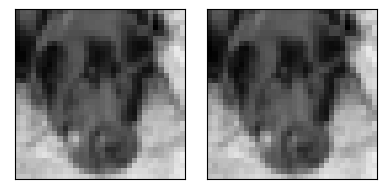

5 Sandal [5]
[ 429.77896 1515.4733   459.53     272.82202  417.25797 1788.4979
  340.41135  285.97467  329.18695  313.67343]


In [919]:

import matplotlib.patches as patches
fig, ax = plt.subplots(1,2,figsize=(4,2))
idx = np.random.randint(10000)
#plt.subplot(121)
ax[0].imshow(np.squeeze(test_images_norm[idx]), cmap='Greys_r', vmin=0, vmax=1)
ax[0].set_xticks(ticks=[])
ax[0].set_yticks(ticks=[])

#plt.subplot(122)
ax[1].imshow(np.squeeze(test_images_norm[idx]), cmap='Greys_r', vmin=0, vmax=1)
#plt.imshow(np.transpose(np.squeeze(pdinp[idx])), vmin=0, vmax=5, cmap='Greys_r')
#ax[1].imshow(np.squeeze(test_images_norm[idx]), cmap='Greys_r', vmin=-5, vmax=5)
rect1 = patches.Rectangle((128 - 51,103),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[1].add_patch(rect1)
rect2 = patches.Rectangle((128 - 102,103),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[1].add_patch(rect2)
rect3 = patches.Rectangle((128 ,103),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[1].add_patch(rect3)
rect4 = patches.Rectangle((128+ 51, 103),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[1].add_patch(rect4)
rect5 = patches.Rectangle((128 - 51+25,128+ 26),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[1].add_patch(rect5)
rect6 = patches.Rectangle((128 - 102+25,128 + 26),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[1].add_patch(rect6)
rect7 = patches.Rectangle((128+25 ,128 + 26),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[1].add_patch(rect7)
rect8 = patches.Rectangle((128 - 51+25,128- 51-25),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[1].add_patch(rect8)
rect9 = patches.Rectangle((128 - 102+25,128 - 51-25),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[1].add_patch(rect9)
rect10 = patches.Rectangle((128+25 ,128 - 51-25),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[1].add_patch(rect10)
ax[1].set_xticks(ticks=[])
ax[1].set_yticks(ticks=[])
plt.tight_layout()
#plt.colorbar()
plt.show()
print(preds[idx], class_names[preds[idx]], test_labels[idx])
print(pdsig[idx])

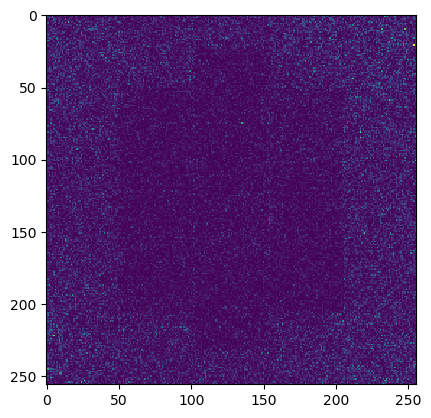

In [754]:
plt.imshow( np.squeeze(  np.abs(pdinp[idx])))
plt.show()

In [773]:
import sklearn.metrics as met
fig, ax = plt.subplots(figsize=(2,2))
cm = met.confusion_matrix(test_labels, preds, normalize='all')
i=ax.imshow(cm, cmap='Purples')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.yticks( ticks=[] ) #[0,1,2,3,4,5,6,7,8,9]  )
plt.xticks( ticks=[0,1,2,3,4,5,6,7,8,9]  )
#plt.ylim([-0.5,9.5])
cbar = fig.colorbar(i)
cbar.set_ticks([])
plt.tight_layout()
plt.show()

In [431]:
def propagate(x):
    N = 28
    d = 120 # plate spacing
    lam = 1    # wavelength 
    P = 0.5  # pitch of metasurface
    df = 1.0/(N*P)
    k = np.pi*2.0/lam
    print("here")

    def phase(i,j):
        i -= N//2
        j -= N//2
        return ((i*df)*(i*df)+(j*df)*(j*df))
    ph  = np.fromfunction(phase,shape=(N,N),dtype=np.float32)
#     H = np.expand_dims(np.fft.fftshift(np.exp(1.0j*k*d)*np.exp(-1.0j*lam*np.pi*d*ph)), axis=2)
    H = np.fft.fftshift(np.exp(1.0j*k*d)*np.exp(-1.0j*lam*np.pi*d*ph))
    
    
    x2 = tf.squeeze(tf.keras.backend.cast(x, dtype='complex64'))
    Fx = tf.fft2d(x2)*H
    
    out = tf.ifft2d(Fx)
    return out

def propagate_np(x):
    N = 28
    d = 120 # plate spacing
    lam = 1    # wavelength 
    P = 0.5  # pitch of metasurface
    df = 1.0/(N*P)
    k = np.pi*2.0/lam
    def phase(i,j):
        i -= N//2
        j -= N//2
        return ((i*df)*(i*df)+(j*df)*(j*df))
    ph  = np.fromfunction(phase,shape=(N,N),dtype=np.float32)
    H = np.fft.fftshift(np.exp(1.0j*k*d)*np.exp(-1.0j*lam*np.pi*d*ph)) 
    print(H.shape)
    Fx = H*(np.fft.fft2(np.squeeze(x)))
    return np.fft.ifft2(Fx)





In [432]:
one = propagate(train_images_norm[:27])
two = propagate_np(train_images_norm[:27])


here
(28, 28)


In [433]:
with tf.Session() as sess:
    onep = one.eval()
onep


array([[[0.686649  +0.46058592j, 0.5893367 +0.81838727j,
         0.43762317+0.8462088j , ..., 0.5078439 +0.48810825j,
         0.3873912 +0.5928114j , 0.608447  +0.30251297j],
        [0.7405254 +0.59770465j, 0.66004837+0.7444194j ,
         0.43617687+0.8446124j , ..., 0.49157158+0.6040572j ,
         0.48980606+0.7012975j , 0.70085603+0.47891667j],
        [0.34375247+0.4076502j , 0.293331  +0.6872643j ,
         0.41259727+0.64154404j, ..., 0.42510355+0.6736348j ,
         0.39158008+0.72071034j, 0.46055785+0.4564002j ],
        ...,
        [0.33229214+0.08728072j, 0.43091252+0.07711011j,
         0.46887448+0.27876744j, ..., 0.27381074+0.15105222j,
         0.39245048+0.13548249j, 0.37307957-0.01221811j],
        [0.5287515 +0.06913576j, 0.52722657+0.24476922j,
         0.4511316 +0.48979527j, ..., 0.2980468 +0.2836031j ,
         0.31834388+0.3325412j , 0.4754831 +0.11050628j],
        [0.49327317+0.16447091j, 0.42932573+0.40261224j,
         0.45461145+0.5760772j , ..., 0.29807

In [434]:
two

array([[[0.68664915+0.46058683j, 0.5893358 +0.81838924j,
         0.43762284+0.84621054j, ..., 0.50784365+0.48810854j,
         0.3873905 +0.59281216j, 0.60844699+0.30251408j],
        [0.74052562+0.597706j  , 0.66004795+0.7444215j ,
         0.4361763 +0.84461449j, ..., 0.4915715 +0.60405829j,
         0.48980562+0.70129897j, 0.70085629+0.47891846j],
        [0.34375243+0.40765055j, 0.29333035+0.6872659j ,
         0.41259747+0.64154555j, ..., 0.42510324+0.67363577j,
         0.3915797 +0.72071133j, 0.46055766+0.45640153j],
        ...,
        [0.33229195+0.08728076j, 0.43091248+0.07711037j,
         0.46887485+0.27876761j, ..., 0.27381026+0.1510524j ,
         0.39245036+0.13548286j, 0.37307971-0.01221758j],
        [0.5287519 +0.06913563j, 0.52722665+0.24476968j,
         0.45113184+0.48979593j, ..., 0.2980463 +0.28360311j,
         0.3183434 +0.33254138j, 0.47548345+0.11050672j],
        [0.49327374+0.16447169j, 0.42932552+0.40261398j,
         0.45461185+0.576079j  , ..., 0.29807

In [438]:
plt.figure(figsize=(3,3))
plt.imshow(np.abs(np.squeeze(onep[10])))
plt.imshow(np.squeeze(np.abs(two[10])))
plt.show()

In [391]:
two.shape

(28, 28)

In [447]:
hg = np.array([[1,2], [3,4]])

In [454]:
hg2 = np.expand_dims(hg, axis=2)

In [452]:
hg2

array([[[1, 2],
        [3, 4]]])

In [455]:
hg2

array([[[1],
        [2]],

       [[3],
        [4]]])

In [462]:
tf.squeeze(train_images_norm[:21])

<tf.Tensor 'Squeeze_10:0' shape=(21, 28, 28) dtype=float64>